### Problem Description

## 1) we should define the target column
## 2) we cleand the text form any punctation or number or stopwords
## 3) we make vectorize the data
## 4) we bulid a model that predict posive or negative form the text description
## 5) save the model in files to reuse it 

Write some details of the problem ... also mention the link of the dataset

### Import Packages

In [1]:
# Add environment Packages paths to conda
import os, sys
# env_name = "food_review"
# sys.path.append(f"C:\\Environments\\{env_name}\\lib\\site-packages\\")

import pandas as pd
import numpy as np

# Text preprocessing packages
import nltk # Text libarary
# nltk.download('stopwords')
import string # Removing special characters {#, @, ...}
import re # Regex Package
from nltk.corpus import stopwords # Stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer # Stemmer & Lemmatizer
from gensim.utils import simple_preprocess  # Text ==> List of Tokens

# Text Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Saving Model
import pickle

# Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
%matplotlib inline

C:\Users\Lenovo\AppData\Roaming\Python\Python37\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Read Dataset

In [2]:
%%time
df = pd.read_csv('Reviews.csv')

Wall time: 3.33 s


In [3]:
f"{df.shape[0]:,} Review"

'568,454 Review'

In [4]:
cols = ['Text', 'Score']
df_text = df[cols].copy()
df_text.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Drop Duplicates
Save the Cleaned data-frame also with the variable `df_text`

In [5]:
df_text=df_text.drop_duplicates().reset_index(drop=True)


In [6]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393675 entries, 0 to 393674
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    393675 non-null  object
 1   Score   393675 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.0+ MB


### Target Variable Pre-Processing
`target` will be 
 - 0 if score < 3 
 - 1 otherwise

In [7]:
def classifer(x):
    if x>=3:
        return 1
    else:
        return 0
df_text['target'] =df_text["Score"].apply(classifer)

#### Plot Countplot for target Variable

D:\python\anaconda\envs\NewEnv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

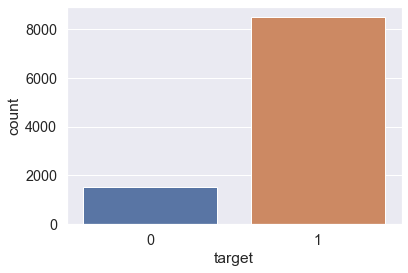

In [8]:
x=df_text['target'].head(10000)
sns.countplot(x)

Notice how such variance is huge ...   
Then we need to down-sample such data ... by which both the positive and negative classes are balanced.

### Balance Data Target

In [9]:
# Sample from positive reviews Same number of negative reviews
NEG_N = df_text.target.value_counts()[0]
df_pos = df_text[df_text['target'] == 1]['Text'].sample(NEG_N, replace=False)
df_text_balanced = pd.concat([df_text.iloc[df_pos.index], df_text[df_text.target == 0]])

D:\python\anaconda\envs\NewEnv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 1500.0)

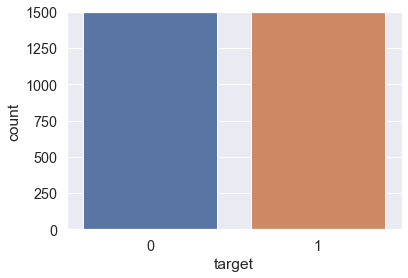

In [10]:
## PLot the target again after balancing
## Write your code here
y=df_text_balanced['target']
sns.countplot(y)
plt.ylim(0,1500)

### Text Pre-Processing

In [11]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
x=stopwords.words('english')
stemmer = SnowballStemmer("english")
lemmatizer= WordNetLemmatizer()

In [13]:
not_words={'no','not','nor',"don't", "aren't", "couldn't", "didn't", "doesn't","hadn't", "hasn't", "haven't",
 "isn't", "mightn't", "mustn't", "needn't", "shouldn't", "wasn't", "weren't" ,"won't", "wouldn't"}

In [14]:
stop_words=set(x).difference(not_words)
stop_words=list(stop_words)
punctuation=list(string.punctuation)

In [15]:
def cleaning(sentence):
    word_list = nltk.word_tokenize(sentence.lower())
    word_list=set(word_list).difference(set(stop_words))
    word_list=set(word_list).difference(set(punctuation))
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w.lower(),"v") for w in list(word_list) if not w.isdigit()])
    return lemmatized_output.lower()

In [16]:
df_text_balanced['clean_text']=df_text_balanced['Text'].apply(cleaning)
df_text_balanced

,Text,Score,target,clean_text
325732,I really like this instant miso. It is delici...,4,1,satisfy love try delicious people really much ...
164127,"If you own this, you have to get one of these ...",5,1,handy love drawers keep machine quieter space ...
171381,Campbells is the best of the canned Manhattan ...,4,1,campbells chicago leaf kid see boil 've best o...
392954,"Great espresso, taste great consistantly. Plus...",5,1,economy tax plus great ship save taste no char...
217044,Each box of Tazo Chai includes 32 ounces of co...,5,1,ounces box include roughly amazon milk able no...
...,...,...,...,...
393654,I just bought this soup today at my local groc...,1,0,evaporate try `` dissatisfy three first spit b...
393655,This soup is mostly broth. Although it has a k...,2,0,try kick third choice red 've broth find taste...
393656,"It is mostly broth, with the advertised 3/4 cu...",2,0,veggies 1.5 bowl meal advertise really tortell...
393667,I had ordered some of these a few months back ...,2,0,eventually order batch months latest br great ...


### Split Test & Training Data

In [17]:
X = df_text_balanced.clean_text
y = df_text_balanced.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(df.shape); print(X_train.shape); print(X_test.shape)

(568454, 10)
(79917,)
(34251,)


### Text Embedding
 - Use `TfidfVectorizer`
 - `fit` on the training data only
 - `transform` on training and test 

In [18]:
vectorizer=TfidfVectorizer(stop_words=stop_words)
vectorizer_tfidf=vectorizer.fit(X)
X_train=vectorizer_tfidf.fit_transform(X_train.values)
X_test=vectorizer_tfidf.transform(X_test.values)

In [19]:
# See the dimensions of your data embeddings before entering to the model
X_train.shape, X_test.shape

((79917, 50044), (34251, 50044))

### Modelling

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

##### Sklearn framework steps
 - init
 - fit
 - predict

In [21]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
preds=clf.predict(X_test)
acc = accuracy_score(preds, y_test)
print(f"Model Accuracy = {round(acc*100,2)}%")

Model Accuracy = 84.5%


### Raw Instance Prediction

In [22]:
from sklearn import metrics
Conf_metrics_tfidf=metrics.confusion_matrix(y_test, preds)
Conf_metrics_tfidf

array([[14879,  2194],
       [ 3115, 14063]], dtype=int64)

In [23]:
def raw_test(review, model, vectorizer):
    review=cleaning(review)
    embedding =vectorizer.transform([review])
    prediction=model.predict(embedding)
    if prediction==1:
        return "Positive"
    else:
        return 'Negative'


In [24]:
review_1 = "That's a good Dish, Good Job"
review_2 = "That's the worst Dish ever tasted"

In [25]:
raw_test(review_1, clf, vectorizer_tfidf)

'Positive'

In [26]:
raw_test(review_2, clf, vectorizer_tfidf)

'Negative'

### Saving Models for Deployment

In [27]:
import pickle

In [28]:
model_name = 'rf_model.pk'
vectorizer_name = 'tfidf_vectorizer.pk'

In [29]:

model_path = os.path.join('/', model_name)
vect_path = os.path.join('/', vectorizer_name)
pickle.dump(clf,open(model_name,"wb"))
pickle.dump(vectorizer,open(vectorizer_name,"wb"))



### Load model Again and test them

In [30]:
loaded_model =pickle.load(open(model_name,'rb'))
loaded_vect = pickle.load(open(vectorizer_name,'rb'))

In [31]:
raw_test(review_1, loaded_model, loaded_vect)

'Positive'

In [32]:
raw_test(review_2, loaded_model, loaded_vect)

'Negative'

# Great Job !
### Now Deploy your ML model using Streamlit Framework